In [1]:
%load_ext autoreload
%autoreload 2
import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')

import time
import torch
import cv2
import copy
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
import numpy as np
from tqdm import tqdm
import wandb
from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f,LogLevel


from torch_openpose.body import Body
from torch_openpose import util
import itertools


In [2]:
def wandb_init(name):
    run = wandb.init(
        project = "mts_tshirt_single", 
        reinit = True,
        name = name,
        config={
            "steps": 200,
            "noise_width": 1024,
            "noise_height": 1024,
            "learning_rate": 0.2
        }
    )
    
    return run 

def get_candidate_from_tensor(rendering_torch, body_estimation):
    PERMUTE_BGR = [2, 1, 0]
     # make torch RGB to BGR and permute and stack
    rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
    # this should be not need, but the rendering has values above 1
    max_val = torch.max(rendering_torch_BGR)
    rendering_torch_BGR = rendering_torch_BGR / max_val
    
    rendering_torch_input = torch.stack([rendering_torch_BGR.permute((2, 0, 1))  - 0.5])
    
    # Render a reference image (no derivatives used yet)
    heatmap_avg, paf_avg = body_estimation.compute_heatmap_paf_avg(rendering_torch_input, ORIG_SHAPE)
    candidate, subset = body_estimation.get_pose(heatmap_avg, paf_avg, ORIG_SHAPE)
    rendering_torch_np =  rendering_torch_BGR.detach().cpu().numpy()
    canvas = copy.deepcopy(rendering_torch_np)
    canvas = util.draw_bodypose(canvas, candidate, subset)
    
    return canvas, candidate, subset, heatmap_avg, paf_avg

def get_image_and_score(scene_path, params_torch, body_estimation, diff_parameter, spp=8):
    thread = Thread.thread()
    thread.file_resolver().append(test_dir)
    logger = thread.logger()
    logger.set_log_level(LogLevel.Warn)
    
    # load scene
    scene = load_file(scene_path)
    params = traverse(scene)
    rendering_torch = render_torch(scene, spp=spp)
    canvas_orig, candidate_orig, subset_orig, heatmap_avg, paf_avg = get_candidate_from_tensor(rendering_torch, body_estimation)
   
    
    # update the params with the new noise value
    params[diff_parameter] = params_torch[diff_parameter].detach().cpu().numpy()
    params.update()
    
    # render scene

    cur_rednering_torch = render_torch(scene, params=params, unbiased=False, spp=spp, malloc_trim=True, **params_torch)
    with torch.no_grad():
        cur_rednering_torch.clamp_(0, 1)
    # transform from rgb to bgr
    
    canvas_noise, candidate_noise, subset_noise, heatmap_avg_noise, paf_avg_noise = get_candidate_from_tensor(cur_rednering_torch, body_estimation)
    
    metric = pose_loss_single_human(subset_noise, subset_orig)
    return canvas_orig[:, :, [2, 1, 0]], canvas_noise[:, :, [2, 1, 0]], metric, heatmap_avg, paf_avg, heatmap_avg_noise, paf_avg_noise


def pose_loss_single_human(newHuman, oldHuman):
    if len(oldHuman) == 0 or len(newHuman) == 0:
        return 0
    new_detected = 0
    old_detected = 0
    for part in range(18):
        if newHuman[0][part] != -1:
            new_detected += 1
        if oldHuman[0][part] != -1:
            old_detected += 1
    return new_detected / old_detected

cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Saved image')

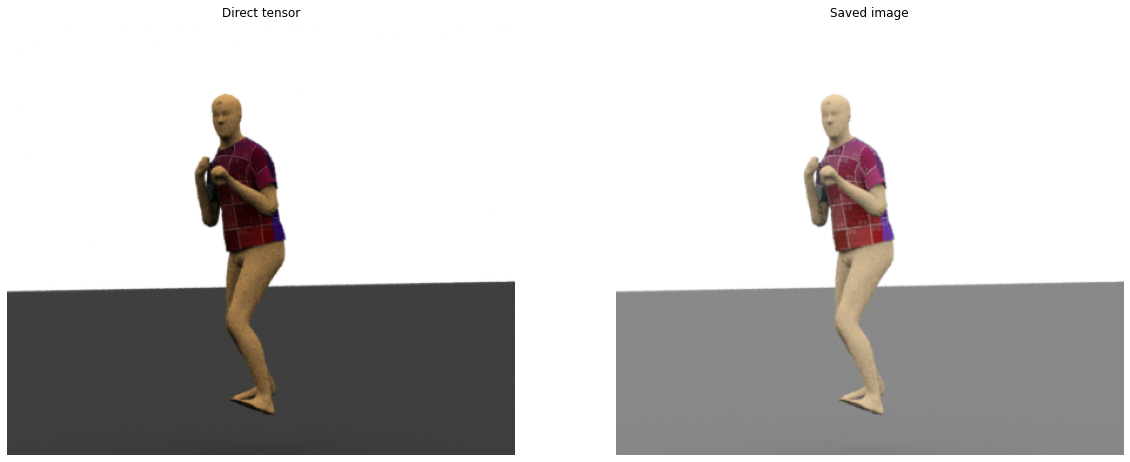

In [4]:
STRIDE = 8
PAD_VALUE = 128
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
#IMAGE_WIDTH, IMAGE_HEIGHT = 215, 180
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

body_estimation = Body(
    '/home/ax/data/programs/pytorch-openpose/model/body_pose_model.pth', True)

# set defaults
body_estimation.imageToTest_padded_shape = ORIG_SHAPE
body_estimation.pad = [0, 0, 0, 0]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

thread = Thread.thread()
thread.file_resolver().append('master_data')
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)
test_dir = 'master_data'

scene_file_path = 'master_data/master_RD_test.xml'
scene = load_file(scene_file_path)
# Find differentiable scene parameters
params = traverse(scene)

# rendering_list = []
# for i in range(8):
#     # Render a reference image (no derivatives used yet)
#     rendering_torch = render_torch(scene, spp=2)
    
#     PERMUTE_BGR = [2, 1, 0]
#     rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]
#     #rendering_list.append(rendering_torch_BGR.permute((2, 0, 1))  - 0.5)
#     rendering_list.append(rendering_torch_BGR)

rendering_torch = render_torch(scene, spp=16)
PERMUTE_BGR = [2, 1, 0]
rendering_torch_BGR = rendering_torch[:, :, PERMUTE_BGR]


crop_size = scene.sensors()[0].film().crop_size()
origal_file_name = '../results/mitsubaPlots/toneMapTest.png'
write_bitmap(origal_file_name, rendering_torch, crop_size)
# permute and stack


#canvas = rendering_torch_BGR.cpu().detach().numpy() 
canvas = rendering_torch.cpu().detach().numpy() 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(canvas)
ax.axis('off')
ax.set_title('Direct tensor')


tone_map_version = cv2.imread(origal_file_name)[..., (2,1,0)]
ax = fig.add_subplot(1, 2, 2)
ax.imshow(tone_map_version)
ax.axis('off')
ax.set_title('Saved image')

In [4]:
run = wandb_init('single try 0/1 16 render')
noise_resolution  = np.array([run.config.noise_width, run.config.noise_height])

diff_parameter = 'simulated.bsdf.reflectance.data'
params.keep([diff_parameter])
params.update()
orig_torch_params = params.torch()

params[diff_parameter] = [0] * (noise_resolution[0] * noise_resolution[1] * 3)
params.update()
params_torch = params.torch()
SPP = 16



# set up optimizer
opt = torch.optim.Adam(params_torch.values(), lr=run.config.learning_rate)
objective = torch.nn.MSELoss()
objective_pixels = torch.nn.L1Loss()

# target
zero_heatmap = torch.zeros((1, 19, 46, 54), device=device)
zero_paf = torch.zeros((1, 38, 46, 54), device=device)
# zero_heatmap = torch.zeros((1, 19, 22, 26), device=device)
# zero_paf = torch.zeros((1, 38, 22, 26), device=device)


for step in tqdm(range(run.config.steps)):
    opt.zero_grad()
    body_estimation.model.zero_grad()

    # render image
    # render multiple times to avoid noise
#     rendering_list = []
#     for i in range(8):
#         cur_rednering_torch = render_torch(scene, params=params, unbiased=False, spp=SPP, malloc_trim=True, **params_torch)
#         with torch.no_grad():
#             cur_rednering_torch.clamp_(0, 1)
#         # transform from rgb to bgr
#         PERMUTE_BGR = [2, 1, 0]
#         rendering_torch_BGR = cur_rednering_torch[:, :, PERMUTE_BGR]
#         rendering_list.append(rendering_torch_BGR)
    
#     rendering_torch_input = torch.stack(rendering_list).mean(0)
    
    cur_rednering_torch = render_torch(scene, params=params, unbiased=False, spp=SPP, malloc_trim=True, **params_torch)
    with torch.no_grad():
        cur_rednering_torch.clamp_(0, 1)
    # transform from rgb to bgr
    PERMUTE_BGR = [2, 1, 0]
    rendering_torch_input = cur_rednering_torch[:, :, PERMUTE_BGR]

    # permute channels to pytorch order and stack
    rendering_torch_input = torch.stack([rendering_torch_input.permute((2, 0, 1))  - 0.5])

    # compute the avg heatmap and paf map
    paf, heatmap = body_estimation.model(rendering_torch_input)

    
    ob_val_heat = objective(heatmap, zero_heatmap)
    ob_val_paf = objective(paf, zero_paf)
    
    y = params_torch[diff_parameter]
    zeros = torch.zeros(y.shape, device=device)
    ones = torch.ones(y.shape, device=device)
    negative_reg = torch.where(y < 0, y, zeros)
    positive_reg = torch.where(y > 1, y, zeros)
    
    ob_negative_reg = objective_pixels(negative_reg, zeros)
    ob_positive_reg = objective_pixels(positive_reg, zeros)
    
    ob_val = (
        ob_val_heat  
        + 2.0 * ob_val_paf 
        + ob_negative_reg 
        + ob_positive_reg
    )
    
    # calc gradient
    ob_val.backward()
    
    # take a step in gradient direction
    opt.step()
    with torch.no_grad():
        params_torch[diff_parameter].clamp_(0, 1)
    
    # log the loss
    wandb.log({'loss': ob_val.item()}, step=step)

    


100%|██████████| 200/200 [02:38<00:00,  1.26it/s]


In [11]:
canvas_orig, canvas_noise, metric, heatmap_avg, paf_avg, heatmap_avg_noise, paf_avg_noise = get_image_and_score(
    scene_file_path, 
    params_torch, 
    body_estimation, 
    diff_parameter, 
    SPP
)

In [12]:
peaks, peaks_cnt = body_estimation.get_peaks(heatmap_avg)
peaks_noise, peaks_noise_cnt = body_estimation.get_peaks(heatmap_avg_noise)
peaks_list = np.array(list(itertools.chain.from_iterable(peaks)))
peaks_noise_list = np.array(list(itertools.chain.from_iterable(peaks_noise)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


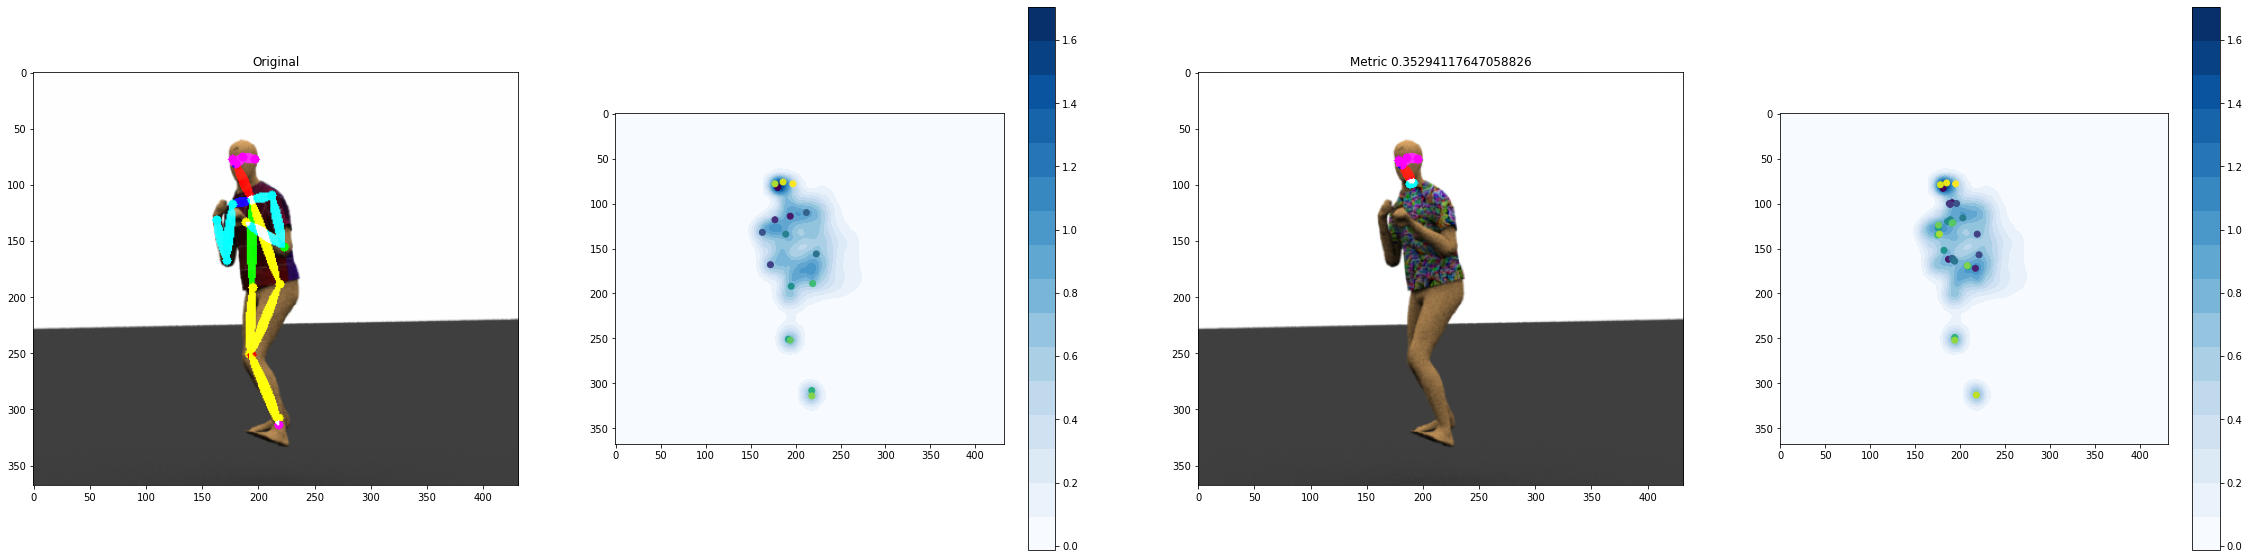

In [13]:
fig = plt.figure(figsize=(40, 10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(canvas_orig)
ax.set_title('Original')

ax = fig.add_subplot(1, 4, 2)
heat = np.sum(heatmap_avg_noise[:, :, :18], axis=2)
heat_image = ax.imshow(heat, cmap=plt.cm.get_cmap('Blues', 16))
ax.scatter(peaks_list[:,0], peaks_list[:,1], c=peaks_list[:,3])
fig.colorbar(heat_image, ax=ax, shrink=1.0)


ax = fig.add_subplot(1, 4, 3)
ax.imshow(canvas_noise)
ax.set_title(f'Metric {metric}')

ax = fig.add_subplot(1, 4, 4)
heat = np.sum(heatmap_avg_noise[:, :, :18], axis=2)
heat_image = ax.imshow(heat,  cmap=plt.cm.get_cmap('Blues', 16)) #, vmin=0, vmax=0.2)
ax.scatter(peaks_noise_list[:,0], peaks_noise_list[:,1], c=peaks_noise_list[:,3])
fig.colorbar(heat_image, ax=ax, shrink=1.0)


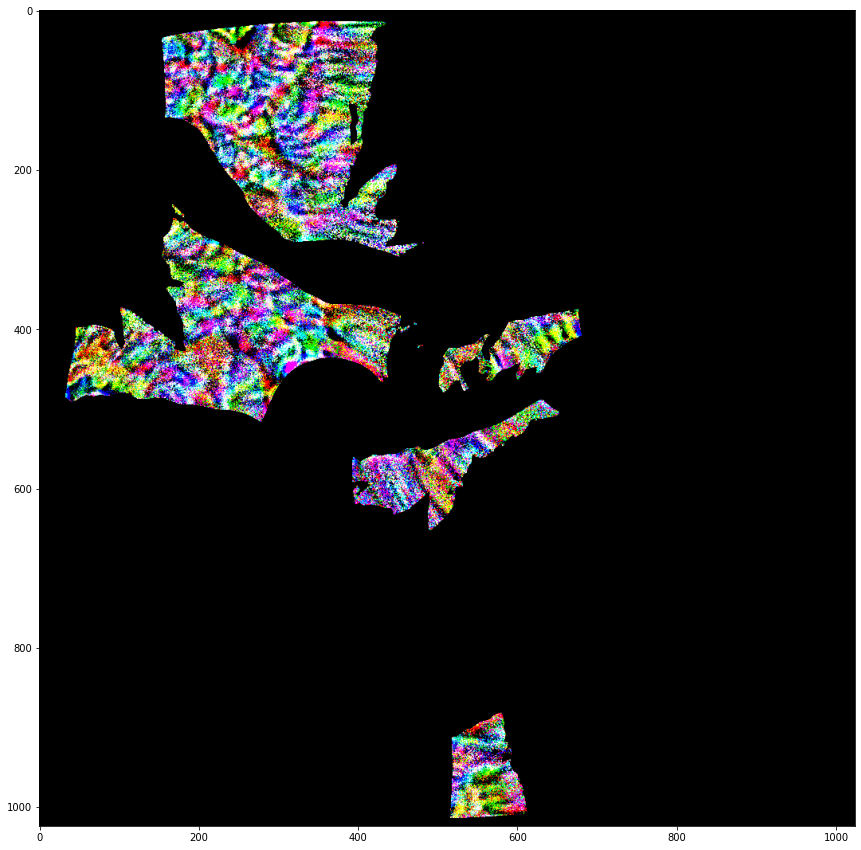

In [14]:
universal_noise_image = params_torch[diff_parameter].detach().cpu().numpy()
universal_noise_image  = universal_noise_image.reshape(noise_resolution[1], noise_resolution[0], -1)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(universal_noise_image)

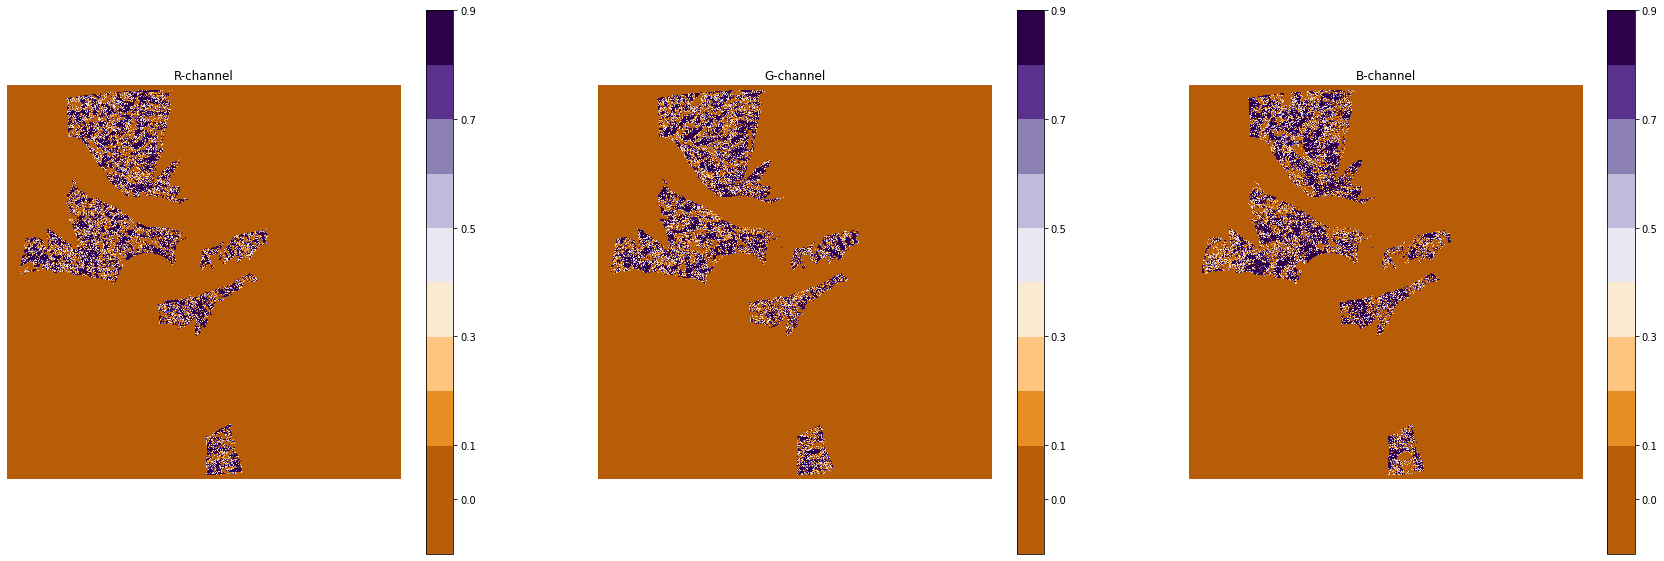

In [9]:
universal_noise_image = params_torch[diff_parameter].detach().cpu().numpy()
universal_noise_image  = universal_noise_image.reshape(noise_resolution[1], noise_resolution[0], -1)


# define the colormap
cmap = plt.get_cmap('PuOr')

# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize and forcing 0 to be part of the colorbar!
bounds = np.arange(np.min(universal_noise_image), np.max(universal_noise_image), .1)
idx=np.searchsorted(bounds,0)
bounds=np.insert(bounds,idx,0)
norm = BoundaryNorm(bounds, cmap.N)


fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
im = ax.imshow(universal_noise_image[:,:, 0], interpolation='none', norm=norm, cmap=cmap)
ax.axis('off')
ax.set_title('R-channel')
fig.colorbar(im, ax=ax)

ax = fig.add_subplot(1, 3, 2)
im = ax.imshow(universal_noise_image[:,:, 1], interpolation='none', norm=norm, cmap=cmap)
ax.axis('off')
ax.set_title('G-channel')
fig.colorbar(im, ax=ax)

ax = fig.add_subplot(1, 3, 3)
im = ax.imshow(universal_noise_image[:,:, 2],  interpolation='none', norm=norm, cmap=cmap)
ax.axis('off')
ax.set_title('B-channel')
fig.colorbar(im, ax=ax)

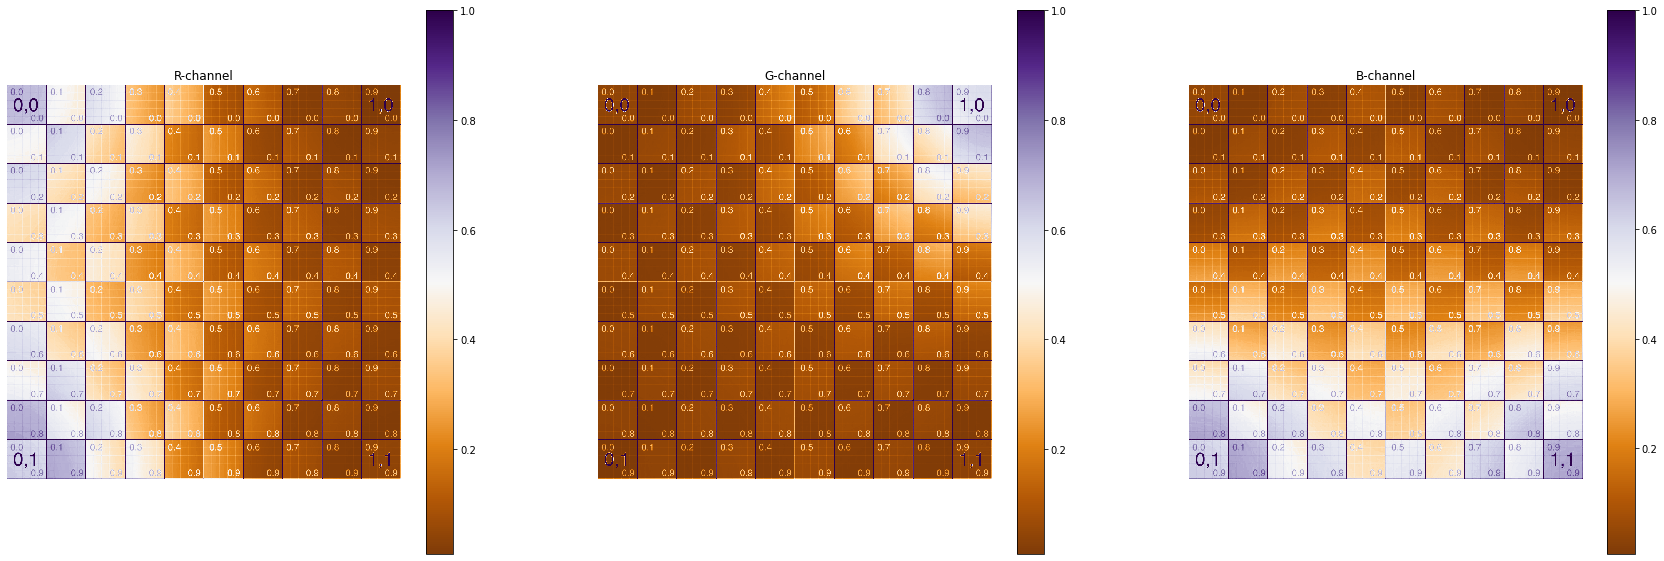

In [10]:
universal_noise_image = orig_torch_params[diff_parameter].detach().cpu().numpy()
universal_noise_image  = universal_noise_image.reshape(noise_resolution[1], noise_resolution[0], -1)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(1, 3, 1)
im = ax.imshow(universal_noise_image[:,:, 0], interpolation='none', cmap='PuOr')
ax.axis('off')
ax.set_title('R-channel')
fig.colorbar(im, ax=ax)

ax = fig.add_subplot(1, 3, 2)
im = ax.imshow(universal_noise_image[:,:, 1], interpolation='none', cmap='PuOr')
ax.axis('off')
ax.set_title('G-channel')
fig.colorbar(im, ax=ax)

ax = fig.add_subplot(1, 3, 3)
im = ax.imshow(universal_noise_image[:,:, 2],  interpolation='none', cmap='PuOr')
ax.axis('off')
ax.set_title('B-channel')
fig.colorbar(im, ax=ax)